In [73]:
import math # for sqrt...
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sb
from sklearn.model_selection import train_test_split # for train test split
from sklearn.metrics import mutual_info_score # for mutual information score
from sklearn.metrics import accuracy_score # for accuracy score
from sklearn.metrics import mean_squared_error # for q6
from sklearn.feature_extraction import DictVectorizer # for one-hot encoding
from sklearn.linear_model import LogisticRegression # for log reg
from sklearn.linear_model import Ridge # for q6
import pickle

from sklearn.metrics import roc_auc_score # for hw4 q1
from matplotlib import pyplot as plt # for hw4 q3
%matplotlib inline
from sklearn.model_selection import KFold # for hw4 q5

In [74]:
df = pd.read_csv("AER_credit_card_data.csv")
# The goal of this homework is to inspect the output of different evaluation metrics 
# by creating a classification model (target column card).

In [75]:
# Preparation
# Create the target variable by mapping yes to 1 and no to 0.
df['card'] = df['card'].map(dict(yes=1, no=0)) # <-- target
df['owner'] = df['owner'].map(dict(yes=1, no=0))
df['selfemp'] = df['selfemp'].map(dict(yes=1, no=0))
# df.head()

In [76]:
# Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. 
# Use train_test_split funciton for that with random_state=1.
X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    df.drop('card', axis = 1),
    df[['card']],
    train_size = 0.8,
    test_size = 0.2,
    random_state = 1)
# print(df.shape)
# print()
# print(X_train_valid.shape)
# print(y_train_valid.shape)
# print()
# print(X_test.shape)
# print(y_test.shape)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid,
    y_train_valid,
    train_size = 0.75,
    test_size = 0.25,
    shuffle = False)
# print(X_train.shape)
# print(y_train.shape)
# print()
# print(X_valid.shape)
# print(y_valid.shape)

In [77]:
# Question 1
# ROC AUC could also be used to evaluate feature importance of numerical variables.
# Let's do that

# For each numerical variable, use it as score and compute AUC with the card variable.
# Use the training dataset for that.
# If your AUC is < 0.5, invert this variable by putting "-" in front
roc_auc_reports = roc_auc_score(y_train, -X_train[['reports']])
print(roc_auc_reports)

roc_auc_dependents = roc_auc_score(y_train, -X_train[['dependents']])
print(roc_auc_dependents)

roc_auc_active = roc_auc_score(y_train, X_train[['active']])
print(roc_auc_active)

roc_auc_share = roc_auc_score(y_train, X_train[['share']])
print(roc_auc_share)

# numerical variables: reports, age, income, share, expenditure, dependents, months, active
# relevant for question: reports, dependents, active, share

# (e.g. -df_train['expenditure'])
# AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

# Which numerical variable (among the following 4) has the highest AUC?
# reports
# dependents
# active
# --> share <--

0.7248644385290347
0.5297643695159223
0.5967958197771863
0.9867396233855862


In [78]:
# Training the model
# From now on, use these columns only:
columns_to_use = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
columns_to_use
X_train_q2 = X_train[columns_to_use].copy()
X_valid_q2 = X_valid[columns_to_use].copy()
X_test_q2 = X_test[columns_to_use].copy()
# Apply one-hot-encoding using DictVectorizer 


In [79]:
X_train_q2.head()

,reports,age,income,share,expenditure,dependents,months,majorcards,active,owner,selfemp
710,1,36.83333,3.0000,0.000400,0.000000,1,12,1,16,1,0
1258,0,35.58333,3.5606,0.109084,323.587500,0,12,1,0,0,0
435,0,25.66667,2.0000,0.004900,7.416667,0,26,1,13,0,0
987,0,25.58333,1.7500,0.000686,0.000000,0,108,0,0,0,0
1286,1,48.66667,6.0000,0.177017,885.085800,3,114,1,19,1,0


In [80]:
train_dict = X_train_q2.to_dict(orient='records')
# print(train_dict)
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
# print(dv.get_feature_names_out())
X_train_q2 = dv.transform(train_dict)

valid_dict = X_valid_q2.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(valid_dict)
X_valid_q2 = dv.transform(valid_dict)

test_dict = X_test_q2.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(test_dict)
X_test_q2 = dv.transform(test_dict)


In [81]:
# and train the logistic regression with these parameters:
model_q2 = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model_q2.fit(X_train_q2, y_train.values.ravel())
card_valid_pred_q2 = model_q2.predict(X_valid_q2)

In [129]:
card_valid_pred_proba = model_q2.predict_proba(X_valid_q2)[:, 1]#.round(3)
#card_valid_pred_proba

In [130]:
# Question 2
# What's the AUC of this model on the validation dataset? (round to 3 digits)

round(roc_auc_score(y_valid, card_valid_pred_q2),3)

# 0.615
# 0.515
# 0.715
# --> 0.995 <--

0.971

In [131]:

#print(np.array(card_valid_pred_proba).shape)
#print(np.array(y_valid.values).shape)

In [135]:
# Question 3
# Now let's compute precision and recall for our model.
# Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.linspace(0, 1, 101)
thresholds
# For each threshold, compute precision and recall
precision = []
recall = []

for t in thresholds:
    true_positive = ((card_valid_pred_proba >= t) &
                     (y_valid.card.values == 1)).sum()
    # print(true_positive)
    false_positive = ((card_valid_pred_proba >= t) &
                      (y_valid.card.values == 0)).sum()
    # print(false_positive)
    false_negative = ((card_valid_pred_proba < t) &
                      (y_valid.card.values == 1)).sum()
    # print(false_negative)
    true_negative = ((card_valid_pred_proba < t) &
                     (y_valid.card.values == 0)).sum()
    # print(true_negative)
    prec = true_positive / (true_positive + false_positive)
    reca = true_positive / (true_positive + false_negative)
    precision.append(prec)
    recall.append(reca)
    #print('%0.2f %0.2f %0.3f' % (t, prec, reca))


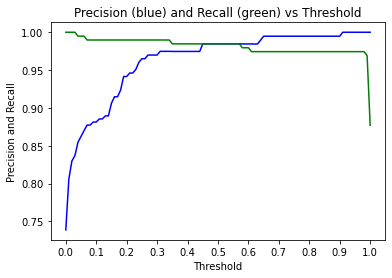

In [136]:
plt.figure(figsize=(6, 4))

plt.plot(thresholds, precision, color='blue')
plt.plot(thresholds, recall, color='green')

plt.title('Precision (blue) and Recall (green) vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Precision and Recall')

plt.xticks(np.linspace(0, 1, 11))

# plt.savefig('04_threshold_accuracy.svg')

plt.show()

In [14]:
# Plot them
# At which threshold precision and recall curves intersect?
# 0.1
# 0.3
# --> 0.6 <--
# 0.8

In [148]:
# Question 4
# Precision and recall are conflicting - when one grows, the other goes down. 
# That's why they are often combined into the F1 score - a metrics that takes into account both
# This is the formula for computing F1:
# F1 = 2 * P * R / (P + R)
# Where P is precision and R is recall.
# Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01
f1 = []
for t in thresholds:
    true_positive = ((card_valid_pred_proba >= t) & (y_valid.card.values == 1)).sum()
    false_positive = ((card_valid_pred_proba >= t) & (y_valid.card.values == 0)).sum()
    false_negative = ((card_valid_pred_proba < t) & (y_valid.card.values == 1)).sum()
    true_negative = ((card_valid_pred_proba < t) & (y_valid.card.values == 0)).sum()
    prec = true_positive / (true_positive + false_positive)
    reca = true_positive / (true_positive + false_negative)
    #precision.append(prec)
    #recall.append(reca)
    f1_t = 2 * prec * reca / ( prec + reca )
    f1.append(f1_t)
    #print('%0.2f %0.3f' % (t, f1_t))

# At which threshold F1 is maximal?
# 0.1
# 0.4
# 0.6
# --> 0.7 <-- ?

[0.8496732026143791, 0.8924485125858123, 0.9069767441860465, 0.9112149532710281, 0.919431279620853, 0.9238095238095239, 0.9282296650717703, 0.9301204819277108, 0.9301204819277108, 0.9323671497584541, 0.9323671497584541, 0.9346246973365618, 0.9346246973365618, 0.9368932038834952, 0.9368932038834952, 0.9460784313725491, 0.9507389162561577, 0.9507389162561577, 0.9554455445544554, 0.9650000000000001, 0.9650000000000001, 0.9674185463659147, 0.9674185463659147, 0.9698492462311559, 0.9747474747474748, 0.9772151898734178, 0.9772151898734178, 0.9796954314720812, 0.9796954314720812, 0.9796954314720812, 0.9796954314720812, 0.9821882951653944, 0.9821882951653944, 0.9821882951653944, 0.9821882951653944, 0.979591836734694, 0.979591836734694, 0.979591836734694, 0.979591836734694, 0.979591836734694, 0.979591836734694, 0.979591836734694, 0.979591836734694, 0.979591836734694, 0.979591836734694, 0.9846153846153847, 0.9846153846153847, 0.9846153846153847, 0.9846153846153847, 0.9846153846153847, 0.98461538

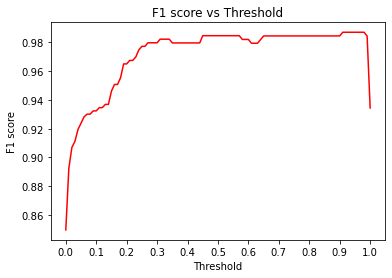

In [139]:
plt.figure(figsize=(6, 4))

plt.plot(thresholds, f1, color='red')

plt.title('F1 score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 score')

plt.xticks(np.linspace(0, 1, 11))

# plt.savefig('04_threshold_accuracy.svg')

plt.show()

In [16]:
# Question 5
# Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

# KFold(n_splits=5, shuffle=True, random_state=1)
# Iterate over different folds of df_full_train
# Split the data into train and validation
# Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
# Use AUC to evaluate the model on validation


In [18]:
kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)
kfold.split(X_train)

<generator object _BaseKFold.split at 0x7ff075b69e40>

In [ ]:
kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.churn.values
    y_val = df_val.churn.values
    
    dv, model = train(df_train, y_train, C=C)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    
#print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))
print(scores)

In [ ]:
# How large is standard devidation of the AUC scores across different folds?
# 0.003
# 0.014
# 0.09
# 0.24

In [ ]:
# Question 6
# Now let's use 5-Fold cross-validation to find the best parameter C
# Iterate over the following C values: [0.01, 0.1, 1, 10]
# Initialize KFold with the same parameters as previously
# Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
# Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
# Which C leads to the best mean score?
# 0.01
# 0.1
# 1
# 10
# If you have ties, select the score with the lowest std. If you still have ties, select the smallest C